In [1]:
import tables, glob, os, time, sys
import numpy as np 
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import axes3d, Axes3D
import matplotlib.colors as colors
from scipy.stats import norm

from stl import mesh
from mpl_toolkits import mplot3d
import scipy.constants as con

In [2]:
def ReadFile(Keys, File): 
    if not os.path.isfile(File):
        print('no')
        return
    else: 
        Data = {}
        try:
            with tables.open_file(File, mode="r") as f: 
                for Key in Keys:    
                    data = f.root._f_get_child(Key)._f_get_child(Key).read()
                    if data is None:
                        print(data)
                    Data[Key] = data
            if Data is None: 
                print(Data)
            return(Data)
        except:
            return 

In [3]:
def GetPhotonFlags(Flags):
    PhotonFlags = {}
    PhotonFlags['NO_HIT'] = (Flags & (0x1 << 0)).astype(bool)   
    PhotonFlags['BULK_ABSORB'] = (Flags & (0x1 << 1)).astype(bool)   
    PhotonFlags['SURFACE_DETECT'] = (Flags & (0x1 << 2)).astype(bool)   
    PhotonFlags['SURFACE_ABSORB'] = (Flags & (0x1 << 3)).astype(bool)   
    PhotonFlags['RAYLEIGH_SCATTER'] = (Flags & (0x1 << 4)).astype(bool)   
    PhotonFlags['REFLECT_DIFFUSE'] = (Flags & (0x1 << 5)).astype(bool)   
    PhotonFlags['REFLECT_SPECULAR'] = (Flags & (0x1 << 6)).astype(bool)    
    PhotonFlags['SURFACE_REEMIT'] = (Flags & (0x1 << 7)).astype(bool)    
    PhotonFlags['SURFACE_TRANSMIT'] = (Flags & (0x1 << 8)).astype(bool)    
    PhotonFlags['BULK_REEMIT'] = (Flags & (0x1 << 9)).astype(bool)   
    PhotonFlags['MATERIAL_REFL'] = (Flags & (0x1 << 10)).astype(bool)  
    PhotonFlags['NAN_ABORT'] = (Flags & (0x1 << 31)).astype(bool)  
    return PhotonFlags

In [120]:
allKeys = ['NumDetected', 'ChannelCharges', 'ChannelIDs', 'NumHitChannels', 
                  'IncidentAngles', 'Flags', 'LastHitTriangle', 'FinalPosition', 'InitialPosition', 'DetectedPos', 
                  'PhotonWavelength'] #'ChannelTimes',

Keys1 = ['Origin', 'LastHitTriangle', 'IncidentAngles', 'DetectorHit', 'Flags', 'FinalPosition', 'NumDetected', 
         'InitialPosition', 'DetectedPos', 'PhotonWavelength']

#to center with WT surface set to detection: 1.0 
# File1 = "h5_files/chroma_nEXO_OD_OD_fullAbs_WT_210621_133834_r5107.h5"
# #to corner with WT surface set to detection: 1.0 s
# File1 = "h5_files/chroma_nEXO_OD_OD_fullAbs_WT_210621_134205_r3434.h5"


# File1 = "h5_files/chroma_nEXO_OD_OD_fullAbs_WT_210624_155631_r4603.h5"

#testing shift of muon input points
File1 = "h5_files/chroma_nEXO_OD_OD_fullAbs_WT_210628_142719_r7732.h5"

#full photons for 10 muons (big file)
#File1 = "h5_files/chroma_nEXO_OD_OD_fullAbs_WT_210708_115311_r1756.h5"
#with wl=300-600 nm
#File1 = "h5_files/chroma_nEXO_OD_OD_fullAbs_WT_210712_152507_r8720.h5"

#10 muons, with PMT's QE applied to the whole water tank detecting
File1 = "h5_files/chroma_nEXO_OD_OD_fullAbs_WT_QE_210714_182139_r8738.h5"
#same 10 muons, but whole water tank detect=1.0
File1 = "h5_files/chroma_nEXO_OD_OD_fullAbs_WT_noQE_210714_181052_r2689.h5"

Data1 = ReadFile(allKeys, File1)

In [121]:
print(Data1.keys())

# for var in Data1.keys():
#     print(var, "- number of entries:", len(Data1[var]))
#     print("     ", Data1[var], '\n')

dict_keys(['NumDetected', 'ChannelCharges', 'ChannelIDs', 'NumHitChannels', 'IncidentAngles', 'Flags', 'LastHitTriangle', 'FinalPosition', 'InitialPosition', 'DetectedPos', 'PhotonWavelength'])


## Looking at wavelength output 

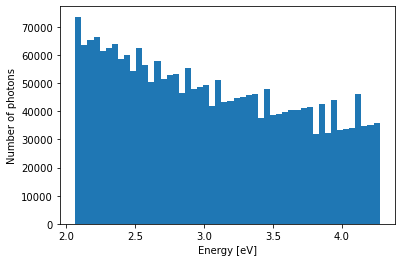

In [127]:
#all photon wavelengths
wavelengths = Data1['PhotonWavelength'] 

#getting photon energy from wavelength
#E = hc/lambda
c = con.c
h = con.h

#assumes wavelen is in nm
def getEnergyFromWavelen(wavelen):
    E_J = h*c / (wavelen*1e-9)
    return E_J/eVtoJ

eVtoJ = con.physical_constants['electron volt-joule relationship'][0]

E = getEnergyFromWavelen(wavelengths)
plt.hist(E, bins=50)
plt.xlabel("Energy [eV]")
plt.ylabel("Number of photons")
plt.show() 

In [123]:
wavelengths = Data1['PhotonWavelength'] 

PhotonFlags_flip = GetPhotonFlags(Data1['Flags'])
wavelen_hits = wavelengths[PhotonFlags_flip['SURFACE_DETECT']]

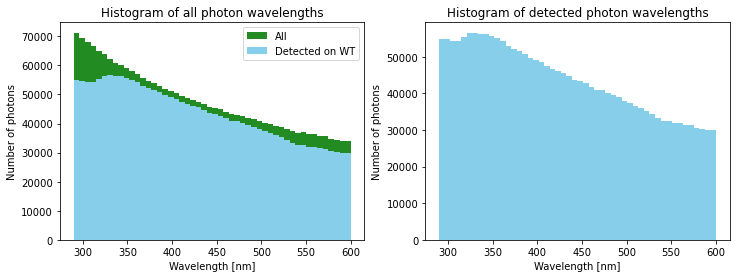

In [124]:
f, axes = plt.subplots(1, 2, figsize=(12,4)) #sharey=True

# print(np.average(wavelengths))

axes[0].set_title("Histogram of all photon wavelengths")
axes[0].hist(wavelengths, bins=50, color="forestgreen", label="All")
axes[0].hist(wavelen_hits, bins=50, color='skyblue', label="Detected on WT")
axes[0].set_xlabel("Wavelength [nm]")
axes[0].set_ylabel("Number of photons")
axes[0].legend()

axes[1].set_title("Histogram of detected photon wavelengths")
axes[1].hist(wavelen_hits, bins=50, color='skyblue')
axes[1].set_xlabel("Wavelength [nm]")
axes[1].set_ylabel("Number of photons")
plt.show() 

## Final position plotting

In [ ]:
def plotLightMap(top, side, bottom, title="Light Map", logscale=False):

    fig, axes = plt.subplots(3, 1, figsize=(6,14))

    Colmap=plt.get_cmap('viridis')
    binsize = (50, 50)
    
    fig.suptitle(title)
    #### top of watertank #####

    empty = np.array([[10000], [10000]])
#     hist1 = axes[0].hist2d(empty[1], empty[0], bins=binsize, cmap=Colmap)
    hist1 = axes[0].hist2d([10000], [10000], bins=binsize, cmap=Colmap)
    
    

    axes[0].set_ylabel("X [mm]")
    axes[0].set_xlabel("Y [mm]")
    # axes[0].tick_params(labelbottom=False,labeltop=True)
    axes[0].xaxis.set_ticks_position('top') 
    axes[0].xaxis.set_label_position('top')
    axes[0].set_title('Top', x =1.1, y=0.5,)

    #### wall of watertank #####
    #Azimuthal position [rad]

    if logscale:  
        hist2 = axes[1].hist2d(side[0], side[1], bins=binsize, cmap=Colmap, norm=colors.LogNorm())
        axes[1].set_facecolor('#440154FF')
        
    else:
        hist2 = axes[1].hist2d(side[0], side[1], bins=binsize, cmap=Colmap)
        
    axes[1].set_xlabel("Azimuthal position [rad]")
    axes[1].set_ylabel("Z [mm]")
    axes[1].set_title('Wall', x =1.1, y=0.5,)
    axes[1].set_xticks(np.arange(-np.pi, np.pi+0.1, np.pi/4))
    labels = [r'-$\pi$', r'$-3\pi/4$', r'$-\pi/2$', r'-$\pi/4$', '$0$', r'$\pi/4$', r'$\pi/2$', r'$3\pi/4$', r'$\pi$',]
    axes[1].set_xticklabels(labels)


    #### bottom of watertank #####
#     hist3 = axes[2].hist2d(bottom[0], bottom[1], bins=binsize, cmap=Colmap)
    if logscale:  
        hist3 = axes[2].hist2d(bottom[1], bottom[0], bins=binsize, cmap=Colmap, norm=colors.LogNorm())
        axes[2].set_facecolor('#440154FF')
        
    else:
        hist3 = axes[2].hist2d(bottom[1], bottom[0], bins=binsize, cmap=Colmap)
    axes[2].set_ylabel("X [mm]")
    axes[2].set_xlabel("Y [mm]")
    axes[2].set_title('Bottom', x =1.1, y=0.5,)

    # Find the min and max of all colors for use in setting the color scale.
    images = [hist1[-1], hist2[-1], hist3[-1]]
    vmin = min(image.get_array().min() for image in images)
    vmax = max(image.get_array().max() for image in images)
    if logscale:
        if vmin <= 0 : #if log scale really we need to replace all the 0s with a very small value
            # as we're just counting counts, it just needs to be less than 1
            vmin = 0.1
        norm = colors.LogNorm(vmin=vmin, vmax=vmax)
        
    else:
        norm = colors.Normalize(vmin=vmin, vmax=vmax) 
    for im in images:
        im.set_norm(norm)

    # plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=.2)

    cbar = fig.colorbar(images[0], ax=axes, shrink=0.95, pad=.14)
    # cbar.set_ticks(np.arange(0, 1.1, 0.5))
    # cbar.set_ticklabels(['low', 'medium', 'high'])
    plt.show()

## Plotting final positions - from hit flags

In [73]:
detectedPos = Data1['DetectedPos']
# finalPos[:,0]

#approximate values to only plot photons with a dimension larger than these for each of the three graphss
topHeight = 5000
bottomHeight = -5000
radius = 6000

#get hits on surfaces
top_hits = []
bottom_hits = []
side_hits = []
all_sides_hits = []
skipped_hits = 0

# PhotonFlags = [GetPhotonFlags(x) for x in Data1['Flags']]
PhotonFlags_flip = GetPhotonFlags(Data1['Flags']) # it's so much faster this way
DetectedBool = PhotonFlags_flip['SURFACE_DETECT']

d = 0

for i, flagtag in enumerate(Data1['Flags']):
#     print(GetPhotonFlags(flagtag))
    if DetectedBool[i]: #only save those that are detected
        x,y,z = detectedPos[d]
        R = np.sqrt(x*x + y*y)
        Az = np.arctan2(y, x)
        
#         print([x,y,z], [R, Az, z])
        
        #save photons that stopped only near the edge of the WT - to be improved later
        if z >= topHeight:
            top_hits.append([x,y])
            all_sides_hits.append([x,y,z])
        elif z <= bottomHeight:
            bottom_hits.append([x,y])
            all_sides_hits.append([x,y,z])
        elif R > radius:
            side_hits.append([Az, z])
            all_sides_hits.append([x,y,z])
        
        d +=1
            
    else:
        skipped_hits +=1
            
top_hits = np.array(top_hits).T
bottom_hits = np.array(bottom_hits).T
side_hits = np.array(side_hits).T
all_sides_hits = np.array(all_sides_hits).T

In [74]:
# print(len(all_sides_hits[0]))

print("Total of %i photons detected." % len(all_sides_hits[0]))

Total of 439997 photons detected.


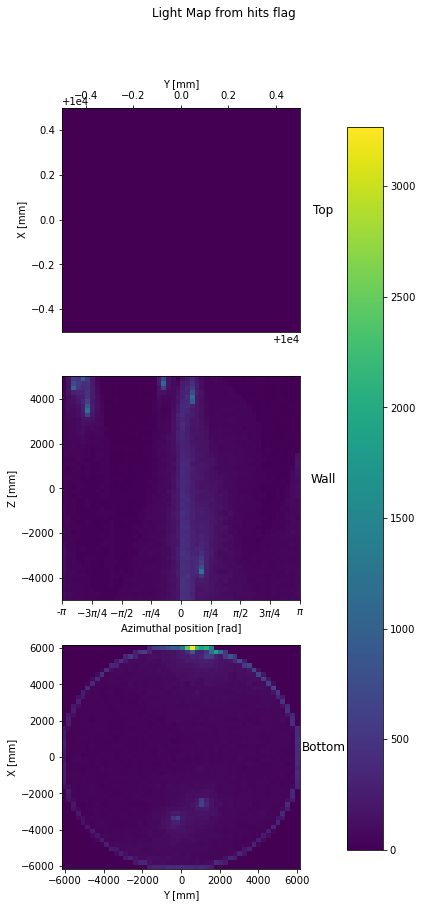

In [75]:
plotLightMap(top_hits, side_hits, bottom_hits, title="Light Map from hits flag")

## Looking at photon paths

In [76]:
I_pos = Data1['InitialPosition'].T
f_pos = Data1['FinalPosition'].T  
d_pos = Data1['DetectedPos'].T  

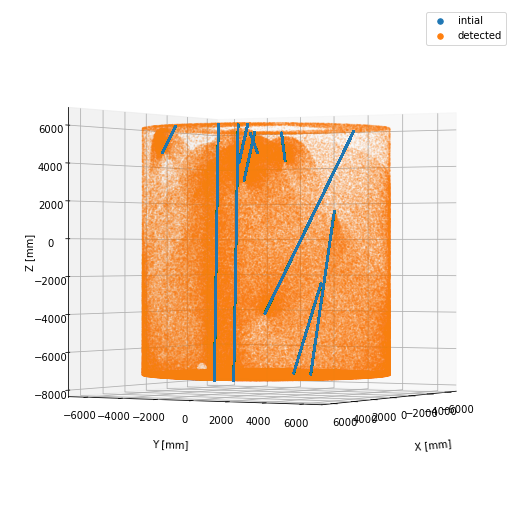

In [77]:
fig = plt.figure(figsize=(7,7))
axes = mplot3d.Axes3D(fig)

axes.scatter3D(I_pos[0], I_pos[1], I_pos[2], 'blue', label='intial', s=0.9)
# axes.scatter3D(f_pos[0], f_pos[1], f_pos[2], 'red', alpha=0.1, s=0.6, label='final')

axes.scatter3D(d_pos[0], d_pos[1], d_pos[2], 'orange', alpha=0.1, s=0.6, label='detected')

# axes.set_xlim3d(-6000, 6000)
# axes.set_ylim3d(-6000, 6000)
# axes.set_zlim3d(-7800, +6730)

axes.set_xlabel("X [mm]")
axes.set_ylabel("Y [mm]")
axes.set_zlabel("Z [mm]")
axes.xaxis.labelpad=20
axes.yaxis.labelpad=15
# axes.zaxis.labelpad=15

lgnd = axes.legend()

#change the marker size manually for both lines
for L in lgnd.legendHandles:
    L._sizes = [30]
    L.set_alpha(1)
    
#change angle of view - (elevation, azimuth) angles in degrees
# ‘elev’ stores the elevation angle in the z plane. ‘azim’ stores the azimuth angle in the x,y plane.
axes.view_init(0, 30)

# 0, 90 - XZ plane; 90, 90 - top view

plt.show()

In [78]:
# for f in Data1['Flags']:
    
flagTag = GetPhotonFlags(Data1['Flags'])

bars = np.zeros(len(flagTag.keys()))
for i, var in enumerate(flagTag.keys()):
    bars[i] = flagTag[var].sum()

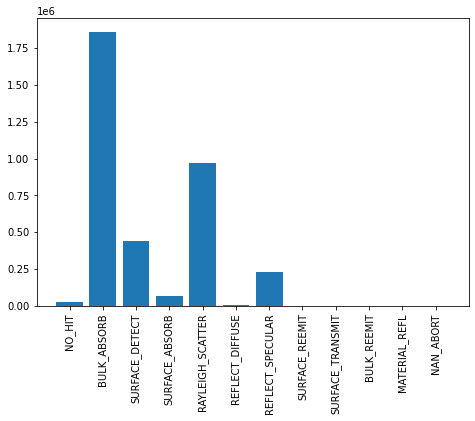

In [79]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(flagTag.keys(),bars)
plt.xticks(rotation=90)
plt.show()

## Looking at PMTs with Channel data

In [ ]:
Keys2 = ['Origin', 'LastHitTriangle', 'IncidentAngles', 'DetectorHit', 'Flags', 'FinalPosition', 'NumDetected', 
         'InitialPosition', 'DetectedPos', 'ChannelCharges', 'ChannelIDs', 'NumHitChannels']

#to center with 12 detecting PMTs
File2 = "h5_files/chroma_nEXO_OD_Rem_test_210622_112356_r4064.h5"

Data2 = ReadFile(Keys2, File1)

In [ ]:
print(Data2.keys())

In [ ]:
Data2['ChannelIDs']
Data2['NumHitChannels']


PMTHit_pos = Data2['DetectorHit'].T
print(PMTHit_pos)

In [ ]:
fig = plt.figure(figsize=(7,7))
axes = mplot3d.Axes3D(fig)

axes.scatter3D(PMTHit_pos[0], PMTHit_pos[1], PMTHit_pos[2], 'blue')
# axes.scatter3D(f_pos[0], f_pos[1], f_pos[2], 'red', alpha=0.1)


# for i in range(len(paths)):
#     direction = np.arange(len(paths[i][0]))#, len(paths[i][0]))

#     axes.plot3D(paths[i][0], paths[i][1], paths[i][2], 'blue', alpha=0.4)
#     p = axes.scatter3D(paths[i][0], paths[i][1], paths[i][2], c=direction, cmap='viridis') #, vmin=0, vmax=ELs_max)
    
# axes.set_xlim3d(-6000, 6000)
# axes.set_ylim3d(-6000, 6000)
# axes.set_zlim3d(-7800, +6730)

axes.set_xlabel("X [mm]")
axes.set_ylabel("Y [mm]")
axes.set_zlabel("Z [mm]")
axes.xaxis.labelpad=20
axes.yaxis.labelpad=15
# axes.zaxis.labelpad=15

# axes.legend()

# fig.colorbar(p, label="Step Number", shrink=0.8)

#change angle of view - (elevation, azimuth) angles in degrees
# ‘elev’ stores the elevation angle in the z plane. ‘azim’ stores the azimuth angle in the x,y plane.
axes.view_init(0, 20)

# 0, 90 - XZ plane; 90, 90 - top views

plt.show()